In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.utils import shuffle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import termtables as tt
warnings.filterwarnings("ignore")

In [2]:
red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 
                       delimiter=';')
white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', 
                         delimiter=';')

In [3]:
red_wine['type'] = 'red'
white_wine['type'] = 'white'

In [4]:
# Create a new dataFrame and put both red and wine dataset inside it. with the new index
wine = pd.DataFrame()
wine = [white_wine, red_wine]
wine = pd.concat(wine)
wine = shuffle(wine)
wine = pd.DataFrame.reset_index(wine)
wine = wine.drop('index', axis=1)

In [10]:
wine.shape

(6497, 13)

In [7]:
wine['type'].value_counts()

TypeError: 'tuple' object is not callable

In [6]:
# normalize the type attribute
wine['type'].value_counts(normalize=True)

white    0.753886
red      0.246114
Name: type, dtype: float64

In [7]:
# change the 'type' attribute to 0 and 1, for red and white respectively before creating the model
wine = pd.get_dummies(wine, drop_first=True)
print(wine)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               6.1             0.380         0.14             3.9      0.060   
1               7.3             0.440         0.20             1.6      0.049   
2               8.0             0.260         0.28             4.8      0.050   
3               8.9             0.330         0.32             1.5      0.047   
4               7.7             0.280         0.24             2.4      0.044   
...             ...               ...          ...             ...        ...   
6492            6.3             0.190         0.33            10.1      0.063   
6493            6.4             0.220         0.32             4.9      0.046   
6494            5.8             0.260         0.18             1.2      0.031   
6495            6.5             0.230         0.33            13.8      0.042   
6496            8.0             0.745         0.56             2.0      0.118   

      free sulfur dioxide  

Scores Table Of Ensemble Voting Classifier: 
+---+--------------------+--------------------+--------------------+
| k | Ensemble Accuracy  | Ensemble Precision | Ensemble Recall    |
+===+====================+====================+====================+
| 1 | 0.9246153846153846 | 0.9966666666666667 | 0.9271317829457364 |
+---+--------------------+--------------------+--------------------+
| 2 | 0.9491916859122402 | 1.0                | 0.9490740740740741 |
+---+--------------------+--------------------+--------------------+
| 3 | 0.9476923076923077 | 0.9902597402597403 | 0.9561128526645768 |
+---+--------------------+--------------------+--------------------+
| 4 | 0.926923076923077  | 1.0                | 0.926923076923077  |
+---+--------------------+--------------------+--------------------+
| 5 | 0.9493087557603687 | 0.9951456310679612 | 0.9534883720930233 |
+---+--------------------+--------------------+--------------------+
| 6 | 0.956989247311828  | 1.0                | 0.95698924

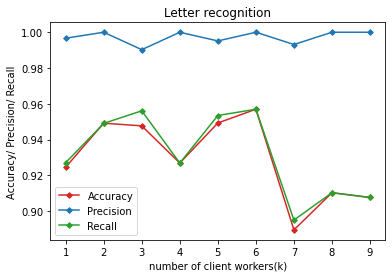

In [16]:
n = len(wine)
models = []

store_acc_esm = []
store_prec_esm = []
store_rec_esm = []
scores_esm_t = []
scores_esm = []
iterations = []
acc = []
prec = []
rec = []
number_of_clients = {}

for n_part in range(2, 11):
    number_of_clients["{0}clients".format(n_part)] = n_part
    dataframes = []
    index_to_partition = len(wine) // n_part
    start = 0
    end = index_to_partition

    wine = pd.DataFrame(wine)

    for partition in range(n_part):
        temporary_df = wine.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_partition
        end += index_to_partition


    # define some expression for quality in our model
    y = dataframes[0]['quality'].apply(lambda y: 'Low Quality' if y < 5
                                 else ('Good Quality' if 5 <= y <=7 
                                       else 'High Quality'))
    # delete quality attribute
    X = dataframes[0].drop('quality', axis=1)


    # Standardize Dataset
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # create a test and train dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    store_acc = []
    store_prec = []
    store_rec = []
    scores_t = []
    scores = []

    for k in range (1, len(dataframes)):
        # define some expression for quality in our model
        y = dataframes[k]['quality'].apply(lambda y: 'Low Quality' if y < 5
                                 else ('Good Quality' if 5 <= y <=7 
                                       else 'High Quality'))
        # delete quality attribute
        X = dataframes[k].drop('quality', axis=1)

        X = scaler.fit_transform(X)

        rfc = RandomForestClassifier()
        rfc.get_params(deep=True)
        trained_model = rfc.fit(X, y)

        y_pred = trained_model.predict(X_test)

#         print("Accuracy Score {0}th of {1} partitioning : ".format(k, n_part), accuracy_score(y_test, y_pred))
        models.append(trained_model)
    
    list_of_models = []
    for i in range(len(models)):
        list_of_models.append(('model{0}'.format(i), models[i]))

    ensemble_rfc = VotingClassifier(estimators=list_of_models, voting='hard')
    ensemble_rfc.fit(X_train, y_train)
    y_pred = ensemble_rfc.predict(X_test)
    
    # Comput Accuracy, Precision and recall from Confusion Matrix 
    cm_esm = confusion_matrix(y_pred, y_test)

    tp = cm_esm[0][0]
    fp = cm_esm[1][0] + cm_esm[2][0]
    fn = cm_esm[0][1] + cm_esm[0][2]
    tn = cm_esm[1][1] + cm_esm[1][2] + cm_esm[2][1] + cm_esm[2][2]

    accuracy_esm = (tp + tn) / (tp + fp + tn + fn)
    precision_esm = tp / (tp + fp)
    recall_esm = tp / (tp + fn)

    scores_esm_t.append([n_part - 1, accuracy_esm, precision_esm, recall_esm])
    scores_esm.append([accuracy_esm, precision_esm, recall_esm])
    iterations.append(scores_esm)


#     print("Ensemble Accuracy Score{0}.forrmat(n_part) : ", accuracy_score(y_test, y_pred))

scores_table = tt.to_string([scores_esm_t], header=["k", "Ensemble Accuracy", "Ensemble Precision", "Ensemble Recall"],
                            style=tt.styles.ascii_thin_double)
print("Scores Table Of Ensemble Voting Classifier: ")
print(scores_table, "\n")

a = []
b = []
c = []

for l in scores_esm:
    a.append(l[0])
    b.append(l[1])
    c.append(l[2])

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.plot([i for i in range(1, 10)], a, 'tab:red', label='Accuracy', marker="D", markersize=4)
ax.plot([i for i in range(1, 10)], b, 'tab:blue', label='Precision', marker="D", markersize=4)
ax.plot([i for i in range(1, 10)], c, 'tab:green', label='Recall', marker="D", markersize=4)

plt.xlabel("number of client workers(k)")
plt.ylabel("Accuracy/ Precision/ Recall")
plt.legend(loc='lower left')
plt.title("Letter recognition")
plt.show()